In [1]:
import torch
from torch import ones, zeros, tensor, eye

from torch.distributions import Categorical

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='white', palette='colorblind', color_codes=True)

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/control_dilemmas')])

from befit.simulate import Simulator
from befit.tasks import bandits
from befit.agents import AIBanditsNaive, AIBanditsFlat, Random

from setup_environment import *

context = torch.from_numpy(np.load('context.npy'))
offers = torch.from_numpy(np.load('offers.npy'))

In [2]:
a = 2*torch.stack([torch.eye(nf), torch.eye(nf)]).reshape(-1, 3)[arm_types] + 1
a = a.repeat(nsub, 1, 1, 1)

lam = torch.tensor([1., 0.])

pars = {
    'nd': 10,
    'ns': 4,  # number of arm types
    'na': na,
    'nc': 6,  # number of contexts
    'nf': nf,
    'ni': len(lam),  # internal states change preference over features, for now they match number of features
}

nd = 10
Bdd = zeros(nd, nd)

d = torch.arange(1., nd+1.)
m = 10.
s = 5.
Bdd[0] = (-(d.log()-m)**2/s - d.log() ).softmax(-1)
Bdd[range(1, nd), range(nd-1)] = 1.

Bccd = zeros(nd, 6, 6)
Bccd[0] = (ones(6, 6) - eye(6))/5
Bccd[1:] = eye(6).repeat(nd-1, 1, 1)

tm_higher = {
    'context': Bccd,
    'duration': Bdd
}

flat_ev_agent1 = AIBanditsFlat(pars, runs=nsub, blocks=blocks, trials=trials, tm={'higher':tm_higher})
flat_ev_agent1.set_parameters(x = [a], depth=trials, lam=lam)

lam = torch.tensor([1.])

pars = {
    'nd': 10,
    'ns': 4,  # number of arm types
    'na': na,
    'nc': 6,  # number of contexts
    'nf': nf,
    'ni': len(lam),  # internal states change preference over features, for now they match number of features
}

flat_ev_agent2 = AIBanditsFlat(pars, runs=nsub, blocks=blocks, trials=trials, tm={'higher':tm_higher})
flat_ev_agent2.set_parameters(x = [a], depth=trials, lam=lam)

lam = torch.tensor([0.])

flat_ev_agent3 = AIBanditsFlat(pars, runs=nsub, blocks=blocks, trials=trials, tm={'higher':tm_higher})
flat_ev_agent3.set_parameters(x = [a], depth=trials, lam=lam)

envs = []
agents = [flat_ev_agent1, flat_ev_agent2, flat_ev_agent3]
for i in range(len(agents)):
    envs.append(bandits.MultiArmedBandit(priors, 
                                transitions, 
                                context,
                                offers,
                                arm_types,
                                nsub=nsub, 
                                blocks=blocks, 
                                trials=trials))

sim = Simulator(envs, agents, runs=nsub, blocks=blocks, trials=trials)
sim.simulate_experiment()

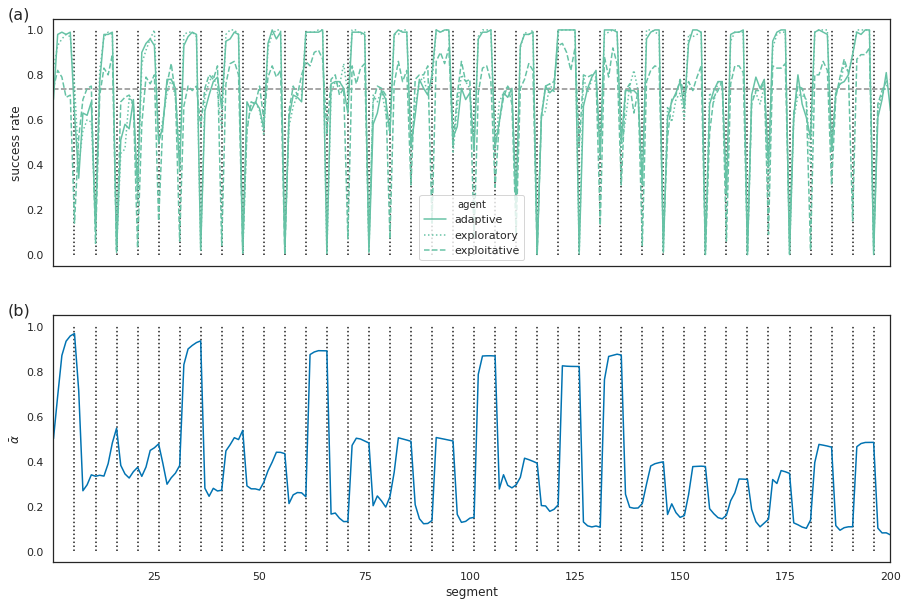

In [13]:
successes = []

out = []
for i in range(len(agents)):
    out.append(sim.stimuli['pair_{}'.format(i)]['outcomes'])

for out1, out2, out3 in zip(*out):
    successes.append(torch.stack([out1[-1][-1], 
                                  out2[-1][-1],
                                  out3[-1][-1]],
                                 -1))
    
successes = torch.stack(successes).float()

maximum = rho**trials + rho**(trials - 1)*(1-rho)*trials

N = nsub//3
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
blks = torch.arange(1, blocks + 1).numpy()
axes[0].plot(blks, successes[..., -3].mean(-1).numpy(), c = colors[0], label='adaptive');
axes[0].plot(blks, successes[..., -2].mean(-1).numpy(), c = colors[0], linestyle=':', label='exploratory');
axes[0].plot(blks, successes[..., -1].mean(-1).numpy(), c = colors[0], linestyle='--', label='exploitative');

axes[0].hlines(maximum, 1, blocks, 'k', linestyle='--', alpha=.5)
axes[0].vlines(np.arange(6, blocks, 5), 0, 1, 'k', linestyle=':')
axes[0].set_ylabel('success rate')
axes[0].legend(loc=8, title='agent')

internals = torch.stack(flat_ev_agent1.priors['internals'])

axes[1].plot(blks, internals.median(-2)[0][:, 0].numpy(), 'b');
axes[1].vlines(np.arange(6, blocks, 5), 0, 1, 'k', linestyle=':')
axes[1].set_ylabel(r'$\bar{\alpha}$')
axes[1].set_xlabel('segment')
axes[0].text(-10, 1.05, '(a)', fontsize=16)
axes[1].text(-10, 1.05, '(b)', fontsize=16)

plt.xlim([1, blocks]);

fig.savefig('success_rate_adaptive.png', bbox_inches='tight', transparent=True, dpi=300)

                              success rate
context variant agent                     
A               adaptive             0.715
                exploitative         0.720
                exploratory          0.710
B               adaptive             0.990
                exploitative         0.820
                exploratory          0.990


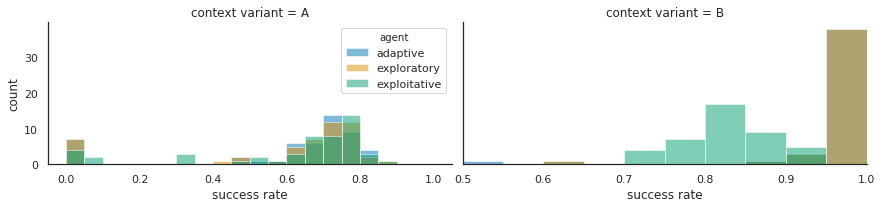

In [12]:
import pandas as pd
tp = ['A', 'B', 'A', 'B', 'A', 'B']

cuttoff = 100 
ms = successes.mean(-2)[cuttoff:]
name = ['adaptive', 'exploratory', 'exploitative']
offs = offers[cuttoff:, 0, 0]
dfs = pd.DataFrame()
for o in range(no):
    locs = offs == o
    for i in range(3):
        df = pd.DataFrame({'success rate': ms[locs, i], 'context variant': tp[o], 'agent': name[i]})
        dfs = dfs.append(df, ignore_index=True)

g = sns.FacetGrid(dfs, col='context variant', hue='agent', height=3, aspect=2, sharex=False, legend_out=False)
g = g.map(plt.hist, 'success rate', bins=np.arange(0, 1.05, .05), alpha=.5).add_legend()

g.axes[0, 0].set_ylabel('count')
g.axes[0, 1].set_xlim([.5, 1.])
print(dfs.groupby(['context variant', 'agent']).median())

g.savefig('success_rate_histogram.png', bbox_inches='tight', transparent=True, dpi=300)